# Saving Data With Mounted Docker Container

 The docker container "porepy-continer-2506-with-volume" is mounted to "D:\ML4pmg" which is now access via "/host_outout/"  
 This allows to save the data to folder for further ML tasks.


 

In [70]:
import shutil
import json

from collections import Counter



# Flow problem random generator

In [2]:
import numpy as np
import porepy as pp
import FTHM_Solver
import scipy.stats as stats
from pprint import pprint


import time
import pandas as pd
import copy
from joblib import Parallel, delayed, parallel_backend
import itertools
import gmsh

import math
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

import random

# Flow set up 

Set up the flow problem, from flow_setup.py  


In [3]:
from porepy.examples.flow_benchmark_2d_case_4 import (
    FlowBenchmark2dCase4Model,
    solid_constants as solid_constants_2d,
)


class StochasticGeometry:
    def set_fractures(self):
        #np.random.seed(self.params.get("seed", 42))

        num_fractures = self.params.get("num_fractures", 10)

        # Generate random fracture orientations. For now, we assume uniform distribution
        # of orientations in the range [0, pi]. We may change this later.
        orientation_distr = stats.uniform(loc=0, scale=np.pi)
        orientation = orientation_distr.rvs(size=num_fractures)

        # Represent fracture lengths as a log-normal distribution. The parameters set
        # here are quite random.
        length_distr = stats.lognorm(s=1, scale=0.5)
        lengths = length_distr.rvs(size=num_fractures)

        # Generate random fracture centers. For now, we assume uniform distribution
        # of positions in the range [0, 1] in both x and y directions.
        position_distr = stats.uniform(loc=0, scale=1)
        positions_x = position_distr.rvs(size=num_fractures)
        positions_y = position_distr.rvs(size=num_fractures)

        # Create the endpoints of the fractures based on the lengths and orientations.
        endpoints = []
        for i in range(num_fractures):
            cx = positions_x[i]
            cy = positions_y[i]
            length = lengths[i]
            theta = orientation[i]

            x0 = cx - 0.5 * length * np.cos(theta)
            y0 = cy - 0.5 * length * np.sin(theta)

            p0 = np.array([x0, y0]).reshape((2, 1))

            x1 = cx + 0.5 * length * np.cos(theta)
            y1 = cy + 0.5 * length * np.sin(theta)
            p1 = np.array([x1, y1]).reshape((2, 1))

            endpoints.append(np.hstack([p0, p1]))

        # Create the fractures as line segments.
        fractures = []
        for point_pairs in endpoints:
            fractures.append(pp.LineFracture(point_pairs))

        # Set the fractures in the model.
        self._fractures = fractures

    def grid_type(self):
        return "simplex"


class Source:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        domain = self.domain
        box = domain.bounding_box_from_polytope()

        x_mean = (box["xmax"] + box["xmin"]) / 2
        y_mean = (box["ymax"] + box["ymin"]) / 2

        src_ambient = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim == self.nd)
        )
        src_fracture = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim == self.nd - 1)
        )
        src_intersection = np.zeros(
            sum(sd.num_cells for sd in subdomains if sd.dim < self.nd - 1)
        )

        if len(self._fractures) == 0:
            # Domain without fractures. Put the source in the center of the domain.
            sd = subdomains[0]
            closest_cell = sd.closest_cell(
                np.array([x_mean, y_mean, 0]).reshape((3, 1))
            )
            src_ambient[closest_cell] = 1.0
        else:
            x, y, z = np.concatenate(
                [sd.cell_centers for sd in subdomains if sd.dim == self.nd - 1], axis=1
            )
            source_loc = np.argmin((x - x_mean) ** 2 + (y - y_mean) ** 2)
            src_fracture[source_loc] = 1

        return super().fluid_source(subdomains) + pp.ad.DenseArray(
            np.concatenate([src_ambient, src_fracture, src_intersection])
        )


class ModelProperties:
    def _is_nonlinear_problem(self) -> bool:
        """Check if the model is nonlinear."""
        return False


class StochasticModel(
    StochasticGeometry,
    FTHM_Solver.IterativeSolverMixin,
    Source,
    ModelProperties,
    pp.SinglePhaseFlow,
):
    pass


class BenchmarkModel(
    Source,
    FTHM_Solver.IterativeSolverMixin,
    ModelProperties,
    FlowBenchmark2dCase4Model,
):
    # We may want to look at this at some point, but for now, consider it untested and
    # optional.
    pass


if True:
    model_class = StochasticModel
else:
    model_class = BenchmarkModel


def reset_model_state(model):
    """Reset the model state to a clean state.

    This can be useful to run several simulations with the same model (discretization
    etc.) but, say, with different solver parameters.
    """
    mdg = model.mdg

    num_cells = sum(sd.num_cells for sd in mdg.subdomains())
    num_interface_cells = sum(intf.num_cells for intf in mdg.interfaces())

    zeros = np.zeros(num_cells + num_interface_cells, dtype=float)
    model.equation_system.set_variable_values(
        values=zeros, additive=False, time_step_index=0
    )
    model.equation_system.set_variable_values(
        values=zeros, additive=False, iterate_index=0
    )

    model.time_manager = pp.TimeManager(schedule=[0, 1], dt_init=1, constant_dt=True)

In [4]:
src = "mesh2d_7fr.msh"  # file created each iteration in current directory
dst_base = "/host_output/mesh2d_7fr_{:03d}.msh"  # output to mounted folder

model_params = {
    "solid_constants": solid_constants_2d,
    "linear_solver": {"preconditioner_factory": FTHM_Solver.mass_balance_factory},
    # Control the number of fractures here.
    "num_fractures": 7,
    # This is the simplest way to control the cell size. You can also do
    # 'cell_size_fracture' and 'cell_size_boundary'.
    #"meshing_arguments": {"cell_size": 0.05,
                         #"cell_size_fracture": 0.1,    # fine mesh around fractures
                          #"cell_size_boundary": 0.2      # coarser mesh at outer boundary
    #                     },
    # Control the name of the gmsh file here.
    "meshing_kwargs": {"file_name": src},
}

model = model_class(model_params)
model.prepare_simulation()

In [5]:

linear_solver_opts = {
    # This line PETSc print the residual norm at each iteration.
    #"ksp_monitor": None,
    #"ksp_view": None,
    "ksp_type": 'bcgs',
    "interface_darcy_flux": {"pc_type": "lu"}, # fix this to ilu for now
    "mass_balance": {"pc_type": "ilu"}
}

model.params["linear_solver"].update({"options": linear_solver_opts})


try:
    pp.run_time_dependent_model(model, {"prepare_simulation": False})
    pprint(f"Simulation completed successfully with {model._krylov_iters[-1]} iterations.")
except RuntimeError as e:
    pprint(f"Runtime error: {e}")

'Simulation completed successfully with 36 iterations.'


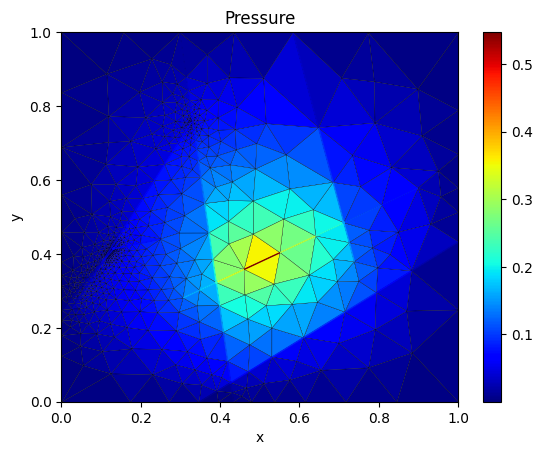

In [6]:
pp.plot_grid(
    model.mdg,
    "pressure",
    figsize=(10, 8),
    linewidth=0.2,
    title='Pressure',
    plot_2d=True,
)

## Small test:

In [7]:
src = "mesh2d_7fr.msh"  # file created each iteration in current directory
dst_base = "/host_output/Data_Large4/mesh2d_50fr_{:04d}.msh"  # output to mounted folder

N =5 # assumed it is less that 999
for i in range(5):
    # Your mesh creation code goes here
    # Example: create mesh2d_50fr.msh in current directory

    # Save a copy with index added
    shutil.copyfile(src, dst_base.format(i))


# Creating a test dataset of mesh, and performance vectors


In [76]:
# Source: where the mesh is now (inside the container)
src = "mesh_2d_Xfr.msh"

# Destination: mounted folder that maps to D:\ML4pmg
dst_base = "/host_output/Data_Large4/mesh2d_Xfr_{:04d}.msh"  # output to mounted folder

In [78]:
model._krylov_iters=[0]
model._solve_time=[0]
model._construction_time=[0]

Here, we use a different mesh every time (no fixed seed), so we need to build a new model at each iteration.

- `model = model_class(model_params); model.prepare_simulation()`  
  → Build a new model with a fresh mesh.

- `reset_model_state(model)`  
  → Reset the internal state, but keep the existing mesh.


## Edited loop, to remove negative solve times. 

I should probably rerun the solver, but I do not want to risk it this time, so I remove the mesh and re-run

In [90]:
all_results[-1]

{'Mesh #': 422,
 'Fractures #': 44,
 'Combination #': 17,
 'KSP Type': 'tfqmr',
 'PC Mass': 'gamg',
 'PC Interface': 'ilu',
 'Converged': False,
 'Krylov Iters': None,
 'Construction Time (s)': None,
 'Solve Time (s)': None,
 'Total Time (s)': None,
 'Tic Toc Time (s)': None}

In [ ]:
# Solver and preconditioner configurations
ksp_types = ["gmres", "bcgs", "tfqmr"]
preconditioners_mass = ["ilu", "sor", "jacobi", "bjacobi", "asm", "gamg"]
preconditioners_interface = ["ilu"]
solver_combinations = list(itertools.product(ksp_types, preconditioners_interface, preconditioners_mass))

#all_results = []
mesh_idx = 423 # where we stopped...
N_meshes = 1000  # total number of meshes to generate

invalid_meshes = 0 

while mesh_idx < N_meshes:
    print(f"\n🧱 Building model with mesh #{mesh_idx:04d}")
    
    num_fractures = random.randint(40, 60)

    # Generate new mesh
    model_params = {
        "solid_constants": solid_constants_2d,
        "linear_solver": {"preconditioner_factory": FTHM_Solver.mass_balance_factory},
        "num_fractures": num_fractures,
        "meshing_kwargs": {"file_name": src},
    }
    model = model_class(model_params)
    try:
        model.prepare_simulation()
    except Exception as e:
        print(f"❌ Failed to prepare model for mesh {mesh_idx:04d}: {e}")
        invalid_meshes += 1
        continue

    mesh_valid = True
    results = []

    for idx, (ksp, pc_interface, pc_mass) in enumerate(solver_combinations):
        print(f"➡️ Mesh {mesh_idx:04d} | Solver #{idx + 1}: {ksp} + {pc_mass} + {pc_interface}")
        reset_model_state(model)

        linear_solver_opts = {
            "ksp_type": ksp,
            "interface_darcy_flux": {"pc_type": pc_interface},
            "mass_balance": {"pc_type": pc_mass}
        }
        model.params["linear_solver"].update({"options": linear_solver_opts})

        try:
            start = time.time()
            pp.run_time_dependent_model(model, {"prepare_simulation": False})
            end = time.time()

            solve_time = model._solve_time[-1]
            construction_time = model._construction_time[-1]

            if solve_time < 0 or construction_time < 0:
                print(f"⚠️ Negative time for mesh {mesh_idx:04d}, discarding mesh...")
                mesh_valid = False
                break

            results.append({
                "Mesh #": mesh_idx,
                "Fractures #": num_fractures,
                "Combination #": idx,
                "KSP Type": ksp,
                "PC Mass": pc_mass,
                "PC Interface": pc_interface,
                "Converged": True,
                "Krylov Iters": model._krylov_iters[-1],
                "Construction Time (s)": construction_time,
                "Solve Time (s)": solve_time,
                "Total Time (s)": construction_time + solve_time,
                "Tic Toc Time (s)": end - start
            })

        except Exception as e:
            #print(f"❌ Solver failed: {ksp} + {pc_mass} + {pc_interface}")
            #print(f"   ⚠️ Error: {type(e).__name__}: {e}")
            results.append({
                "Mesh #": mesh_idx,
                "Fractures #": num_fractures,
                "Combination #": idx,
                "KSP Type": ksp,
                "PC Mass": pc_mass,
                "PC Interface": pc_interface,
                "Converged": False,
                "Krylov Iters": None,
                "Construction Time (s)": None,
                "Solve Time (s)": None,
                "Total Time (s)": None,
                "Tic Toc Time (s)": None
            })

    if mesh_valid:
        all_results.extend(results)
        # Save mesh to disk
        shutil.copyfile(src, dst_base.format(mesh_idx))
        
        # Build fracture + mesh metadata
        
        fracture_data = [frac.pts.tolist() for frac in model.fractures]
        interfaces = model.mdg.interfaces()  # list of InterfaceGrid (== MortarGrid) objects

        iface_dim_counts = Counter()
        mortar_cell_counts = Counter()

        for iface in interfaces:
            mortar_dim = iface.dim  # <-- iface is already a MortarGrid
            iface_dim_counts[mortar_dim] += 1
            mortar_cell_counts[mortar_dim] += iface.num_cells


        n_interfaces = {
            "total": int(len(interfaces)),
            "2d-1d": int(iface_dim_counts.get(1, 0)),
            "1d-0d": int(iface_dim_counts.get(0, 0))
        }

        n_mortar_cells = {
            "2d-1d": int(mortar_cell_counts.get(1, 0)),
            "1d-0d": int(mortar_cell_counts.get(0, 0))
        }

        # Final metadata dict
        mesh_meta = {
            "mesh_id": mesh_idx,
            "fractures": fracture_data,
            "n_grids": {"total": sum(n_grids.values()), **n_grids},
            "n_cells": n_cells,
            "n_interfaces": n_interfaces,
            "n_mortar_cells": n_mortar_cells,
            "dim_max": dim_max,
            "dim_min": dim_min
        }

        # Save to JSON
        with open(f"/host_output/Data_Large4/mesh_meta_{mesh_idx:04d}.json", "w") as f:
            json.dump(mesh_meta, f)

        
        mesh_idx += 1

        
    else: 
        invalid_meshes += 1 

# Save full results
df_results = pd.DataFrame(all_results)
df_results.to_csv("/host_output/Data_Large4/solver_timings.csv", index=False)
print(f"\n❌ Total invalid meshes discarded and regenerated: {invalid_meshes}")


🧱 Building model with mesh #0000

➡️ Mesh 0000 | Solver #1: gmres + ilu + ilu
➡️ Mesh 0000 | Solver #2: gmres + sor + ilu
➡️ Mesh 0000 | Solver #3: gmres + jacobi + ilu
➡️ Mesh 0000 | Solver #4: gmres + bjacobi + ilu
➡️ Mesh 0000 | Solver #5: gmres + asm + ilu
➡️ Mesh 0000 | Solver #6: gmres + gamg + ilu
➡️ Mesh 0000 | Solver #7: bcgs + ilu + ilu
➡️ Mesh 0000 | Solver #8: bcgs + sor + ilu
➡️ Mesh 0000 | Solver #9: bcgs + jacobi + ilu
➡️ Mesh 0000 | Solver #10: bcgs + bjacobi + ilu
➡️ Mesh 0000 | Solver #11: bcgs + asm + ilu
➡️ Mesh 0000 | Solver #12: bcgs + gamg + ilu
➡️ Mesh 0000 | Solver #13: tfqmr + ilu + ilu
➡️ Mesh 0000 | Solver #14: tfqmr + sor + ilu
➡️ Mesh 0000 | Solver #15: tfqmr + jacobi + ilu
➡️ Mesh 0000 | Solver #16: tfqmr + bjacobi + ilu
➡️ Mesh 0000 | Solver #17: tfqmr + asm + ilu
➡️ Mesh 0000 | Solver #18: tfqmr + gamg + ilu

🧱 Building model with mesh #0001

➡️ Mesh 0001 | Solver #1: gmres + ilu + ilu
➡️ Mesh 0001 | Solver #2: gmres + sor + ilu
➡️ Mesh 0001 | Solver #

AssertionError: 

In [81]:
df_results = pd.DataFrame(all_results)
df_results.to_csv("/host_output/Data_Large4/solver_timings.csv", index=False)
print(f"\n❌ Total invalid meshes discarded and regenerated: {invalid_meshes}")


❌ Total invalid meshes discarded and regenerated: 0


In [80]:
type(model.mdg)
      

AttributeError: 'StochasticModel' object has no attribute 'mdg'

In [ ]:


interfaces = model.mdg.interfaces()  # list of InterfaceGrid (== MortarGrid) objects

iface_dim_counts = Counter()
mortar_cell_counts = Counter()

for iface in interfaces:
    mortar_dim = iface.dim  # <-- iface is already a MortarGrid
    iface_dim_counts[mortar_dim] += 1
    mortar_cell_counts[mortar_dim] += iface.num_cells


n_interfaces = {
    "total": int(len(interfaces)),
    "2d-1d": int(iface_dim_counts.get(1, 0)),
    "1d-0d": int(iface_dim_counts.get(0, 0))
}

n_mortar_cells = {
    "2d-1d": int(mortar_cell_counts.get(1, 0)),
    "1d-0d": int(mortar_cell_counts.get(0, 0))
}

# Final metadata dict
mesh_meta = {
    "mesh_id": mesh_idx,
    "fractures": fracture_data,
    "n_grids": {"total": sum(n_grids.values()), **n_grids},
    "n_cells": n_cells,
    "n_interfaces": n_interfaces,
    "n_mortar_cells": n_mortar_cells,
    "dim_max": dim_max,
    "dim_min": dim_min
}

# Save to JSON
with open(f"/host_output/Data_Large4/mesh_meta_{mesh_idx:04d}.json", "w") as f:
    json.dump(mesh_meta, f)


In [82]:
# Make a new column for solver labels
# This combines the KSP type, PC mass, and PC interface into a single string.
df_results["Solver Label"] = (
    df_results["KSP Type"] + " + " +
    df_results["PC Mass"] + " + " +
    df_results["PC Interface"]
)
df_results.head()

,Mesh #,Fractures #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label
0,0,48,0,gmres,ilu,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + ilu + ilu
1,0,48,1,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + sor + ilu
2,0,48,2,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu
3,0,48,3,gmres,bjacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + bjacobi + ilu
4,0,48,4,gmres,asm,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + asm + ilu


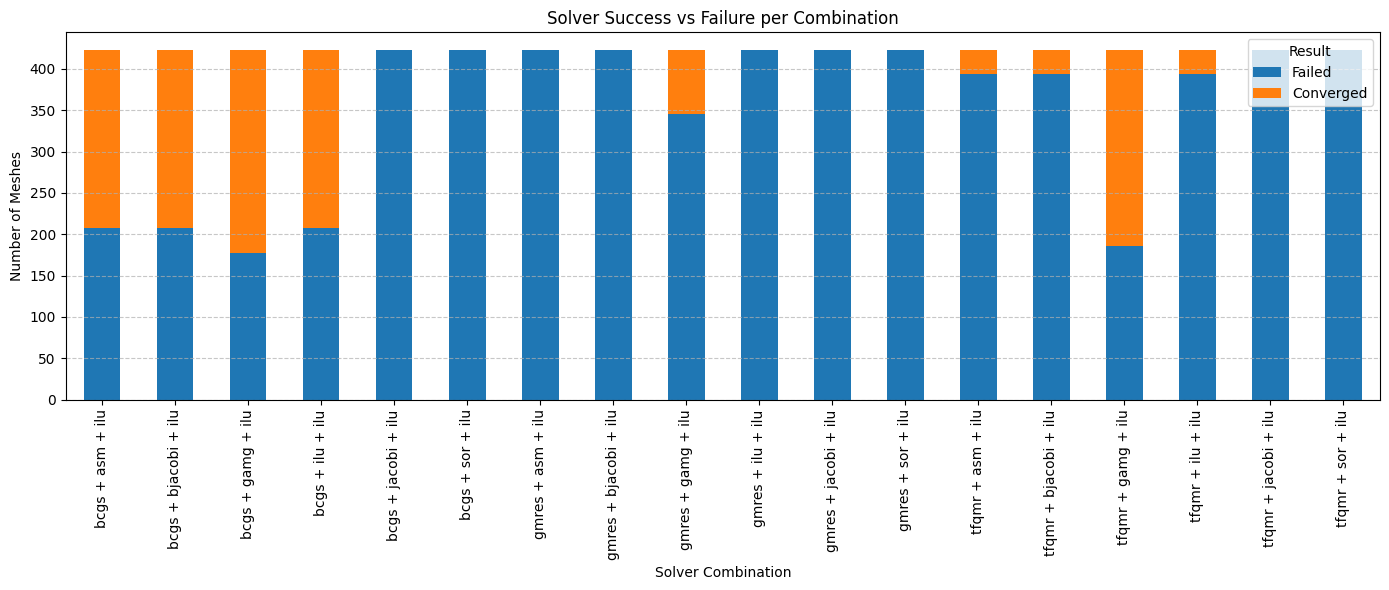

In [83]:
# Count how many converged/failed for each solver label
summary = df_results.groupby(["Solver Label", "Converged"]).size().unstack(fill_value=0)

# Optional: rename columns for clarity
summary.columns = ["Failed", "Converged"] if False in summary.columns else summary.columns

# Plot
summary.plot(kind="bar", stacked=True, figsize=(14, 6))
plt.xlabel("Solver Combination")
plt.ylabel("Number of Meshes")
plt.title("Solver Success vs Failure per Combination")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(title="Result")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [84]:
summary

,Failed,Converged
Solver Label,,
bcgs + asm + ilu,208,215
bcgs + bjacobi + ilu,208,215
bcgs + gamg + ilu,177,246
bcgs + ilu + ilu,208,215
bcgs + jacobi + ilu,423,0
bcgs + sor + ilu,423,0
gmres + asm + ilu,423,0
gmres + bjacobi + ilu,423,0
gmres + gamg + ilu,345,78


In [85]:

# Replace failed timings with the 2 x max timing in the dataset


total_times = df_results["Total Time (s)"].copy()

# Find max time (excluding None)
max_time = 2*total_times.dropna().max()

# Fill missing times with max_time
df_results["Adjusted Time (s)"] = df_results["Total Time (s)"].fillna(max_time)
df_results.head()


,Mesh #,Fractures #,Combination #,KSP Type,PC Mass,PC Interface,Converged,Krylov Iters,Construction Time (s),Solve Time (s),Total Time (s),Tic Toc Time (s),Solver Label,Adjusted Time (s)
0,0,48,0,gmres,ilu,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + ilu + ilu,2.964206
1,0,48,1,gmres,sor,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + sor + ilu,2.964206
2,0,48,2,gmres,jacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + jacobi + ilu,2.964206
3,0,48,3,gmres,bjacobi,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + bjacobi + ilu,2.964206
4,0,48,4,gmres,asm,ilu,False,NaN,NaN,NaN,NaN,NaN,gmres + asm + ilu,2.964206


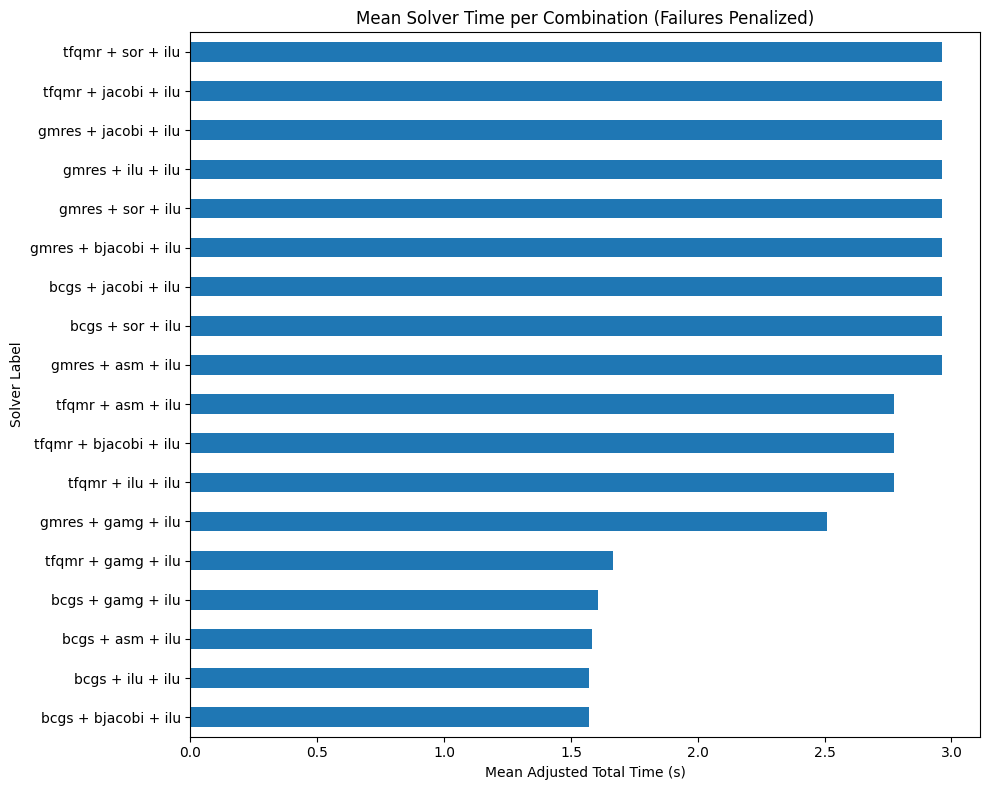

In [86]:
#Compute mean adjusted time per solver
mean_times = df_results.groupby("Solver Label")["Adjusted Time (s)"].mean().sort_values()

# Step 4: Plot
mean_times.plot(kind="barh", figsize=(10, 8))
plt.xlabel("Mean Adjusted Total Time (s)")
plt.title("Mean Solver Time per Combination (Failures Penalized)")
plt.tight_layout()
plt.show()


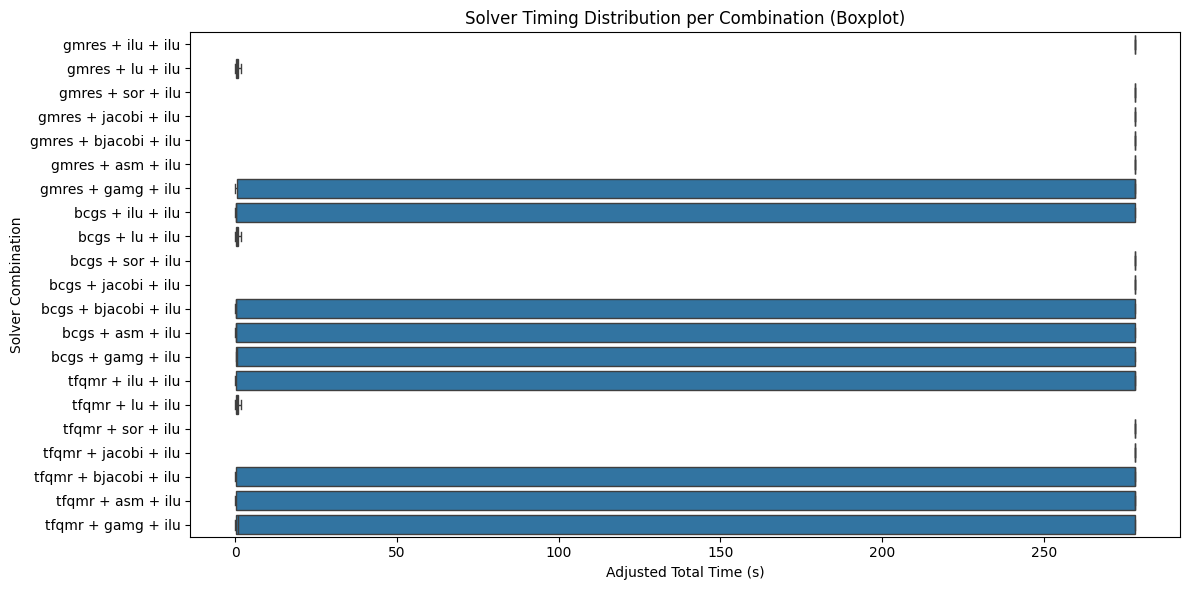

In [20]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_results,
    x="Adjusted Time (s)",
    y="Solver Label",
    showfliers=False  # hide outliers for clarity; remove to see all
)

plt.xlabel("Adjusted Total Time (s)")
plt.ylabel("Solver Combination")
plt.title("Solver Timing Distribution per Combination (Boxplot)")
plt.tight_layout()
plt.show()

In [21]:
#ct=df_results["Construction Time (s)"]
len(df_results)

21000

In [22]:
for i in range(len(df_results)):
    if df_results['Construction Time (s)'][i]<0:
        print(f"Negative construction time at index {i}: {df_results['Construction Time (s)'][i]}")
    if df_results['Solve Time (s)'][i]<0:
        print(f"Negative solve time at index {i}: {df_results['Solve Time (s)'][i]}")

In [18]:
df_results.iloc[1952]

Mesh #                                   92
Combination #                            20
KSP Type                              tfqmr
PC Mass                                gamg
PC Interface                            ilu
Converged                              True
Krylov Iters                           52.0
Construction Time (s)              0.007509
Solve Time (s)                     0.007483
Total Time (s)                     0.014992
Tic Toc Time (s)                   0.172393
Solver Label             tfqmr + gamg + ilu
Adjusted Time (s)                  0.014992
Name: 1952, dtype: object

In [19]:
df_results.iloc[-1]

Mesh #                                  999
Combination #                            20
KSP Type                              tfqmr
PC Mass                                gamg
PC Interface                            ilu
Converged                              True
Krylov Iters                           35.0
Construction Time (s)              0.007629
Solve Time (s)                     0.005124
Total Time (s)                     0.012753
Tic Toc Time (s)                    0.15506
Solver Label             tfqmr + gamg + ilu
Adjusted Time (s)                  0.012753
Name: 20999, dtype: object

In [87]:
df_results.to_csv("/host_output/Data_Large4/solver_times.csv", index=False)

In [88]:
print(len(model._solve_time))
print(len(df_results))


7651
7614


In [24]:
model._solve_time[1954] 

0.33153223991394043

In [25]:
model._solve_time[-1]
model._construction_time[-1]

0.06195855140686035

In [26]:
solve_times = np.array(model._solve_time)
construction_times = np.array(model._construction_time)
print(f"Number when solve times were negative: {np.sum(solve_times<0)} out of {len(solve_times)}")
print(f"Number when construction times were negative: {np.sum(construction_times<0)} out of {len(construction_times)}")
#plt.plot(solve_times>0, 'o', label='Positive Solve Time (True/False)')
#plt.plot(construction_times>0, 'x', label='Positive Construction Time (True/False)')

Number when solve times were negative: 0 out of 21001
Number when construction times were negative: 0 out of 21001
